# prepair for plotting - vibration data contextualisation
## big part

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import fun
import math

import matplotlib.pyplot as plt

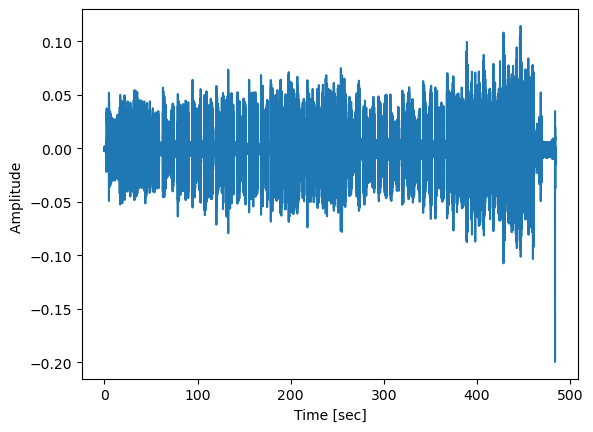

,Chan 0,Chan 1
time,,
0.000000,0.000201,-0.000333
0.000020,0.000795,-0.001061
0.000039,0.000773,-0.000256
0.000059,0.000077,-0.000203
0.000078,0.000562,-0.000819
...,...,...
483.999629,-0.000826,-0.000798
483.999648,-0.000824,0.000036
483.999668,-0.000383,-0.000963


In [2]:
#record import:
record = pd.read_csv('Xbignew_0_0_t2.csv') #X1_1_28_09  19_6_3
record = record.drop(record.columns[2], axis=1) #drop 3rd (empty) column

record["time"] = np.arange(len(record[' Chan 1']))/51200
record = record.set_index(["time"])

y = record[' Chan 1']#.iloc[300000 : 301000]

fs = 51200 #samplerate
samples = len(y) #total number of samples
x = np.arange(samples) / fs #array of timestamps

vibdata = record[' Chan 1']

plt.plot(x,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude ')
plt.show()
record

In [3]:
smoothed_envelop = fun.envelope_F(vibdata, window_size=5)

In [4]:
segments = fun.find_higher_vibration_segments(np.array(smoothed_envelop), threshold=0.01)
len(segments)

40

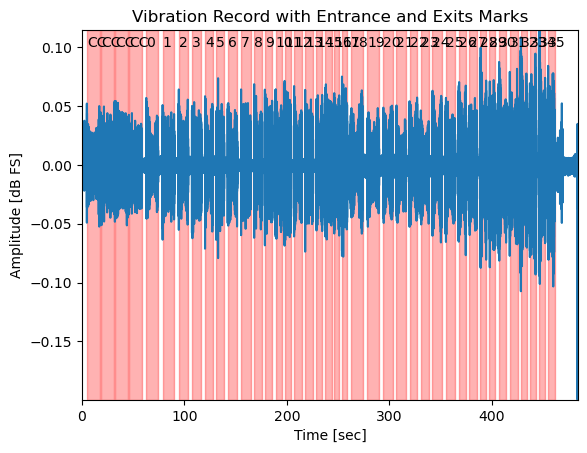

In [5]:
fun.plot_timewindowing(segments, vibdata)

In [6]:
plane_context = fun.open_pkl("context_0_0.pkl")
len(plane_context)

34

In [17]:
segment_i = 0
params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
params_ranges, params_current

({'a_e': [0.2, 0.5, 0.8],
  'v_c': [125.60000000000001, 157, 188.4],
  'f_z': [0.0208, 0.026, 0.0312],
  'a_p': [1, 2],
  'd': [5],
  'flutes': [2],
  'direct': [0, 1]},
 {'a_e': 0.2,
  'v_c': 125.60000000000001,
  'f_z': 0.0208,
  'a_p': 1.0,
  'd': 5.0,
  'flutes': 2.0,
  'direct': 'Gleich'})

In [8]:
def select_vibdata(vib_data, segments, segment_i):
    segment_i += 4  # skip CC (circle clean)
    segment = segments[segment_i]
    start_t, end_t = segment[0], segment[1]
    cropped = vib_data[(vib_data.index > start_t) & (vib_data.index < end_t)]
    fs = 51200
    return cropped

vibseg = select_vibdata(vibdata, segments, segment_i)
vibseg

time
62.756270    0.003797
62.756289   -0.011780
62.756309    0.003395
62.756328   -0.006483
62.756348    0.001054
               ...   
74.255371    0.003786
74.255391    0.004922
74.255410    0.003366
74.255430    0.002530
74.255449    0.003711
Name:  Chan 1, Length: 588759, dtype: float64

In [9]:
seg_direct = params_current['direct']
seg_direct

'Gleich'

In [28]:
def find_comparison_windows(segments, segment_i, seg_direct):
    segment_i += 4 #skip CC (circle clean)
    segment = segments[segment_i]
    segment_length = segment[1]-segment[0]
    delta = segment_length/4/2 #delta for non defect
    
    non_defects_time = segment_length/4+segment[0]+delta, segment_length/4*2+segment[0]+delta, segment_length/4*3+segment[0]+delta
    
    defects_time = segment_length/4+segment[0], segment_length/4*2+segment[0], segment_length/4*3+segment[0]
    
    
    #window time span: 
    window_span = segment_length/5/6*2 #span of defective cut              ### ADJUST
    
    #direction correction:
    if seg_direct == 'Gleich': # 1, Gleich???
        dir_cor_val = 0.2 # at Gleich the defect is later  ### ADJUST
    else: dir_cor_val = 2.2 #else Gegen                                  ### ADJUST
    
    #correction value: (factor of window_span to normalise it)
    cor_val =  window_span*dir_cor_val #because tool is slightly early  

    
    # NONDEFECT
    non_defects_start_end = [[non_defects_time[0]-window_span/2+cor_val, non_defects_time[0]+window_span/2+cor_val],
                         [non_defects_time[1]-window_span/2+cor_val, non_defects_time[1]+window_span/2+cor_val],
                         [non_defects_time[2]-window_span/2+cor_val, non_defects_time[2]+window_span/2+cor_val]]

    #DEFECT
    defects_start_end = [[defects_time[0]-window_span/2+cor_val, defects_time[0]+window_span/2+cor_val],
                         [defects_time[1]-window_span/2+cor_val, defects_time[1]+window_span/2+cor_val],
                         [defects_time[2]-window_span/2+cor_val, defects_time[2]+window_span/2+cor_val]]
    
    return non_defects_start_end, defects_start_end


seg_direct = params_current['direct']
print(type(seg_direct))
non_defects_time, defects_time = find_comparison_windows(segments, segment_i, seg_direct)
non_defects_time, defects_time

<class 'str'>


([[66.83847265624999, 67.60508723958333],
  [69.71327734375, 70.47989192708333],
  [72.58808203125, 73.35469661458333]],
 [[65.4010703125, 66.16768489583333],
  [68.275875, 69.04248958333334],
  [71.1506796875, 71.91729427083334]])

In [11]:
def cut_vibration_data(vibration_data, time_spans):
    """
    Cut the vibration data into subsets based on specified time spans.

    Parameters:
    - vibration_data: pandas.core.series.Series
        Time series data with time and amplitude.
    - time_spans: list of lists
        List of time spans [[start_time1, end_time1], [start_time2, end_time2], ...]

    Returns:
    - list of pandas.core.series.Series
        List of subsets of vibration data based on time spans.
    """
    subsets = []

    for span in time_spans:
        start_time, end_time = span
        subset = vibration_data[(vibration_data.index >= start_time) & (vibration_data.index <= end_time)]
        subsets.append(subset)

    return subsets

In [12]:
non_defect_subsets = cut_vibration_data(vibseg, non_defects_time)
non_defect_subsets
defect_subsets = cut_vibration_data(vibseg, defects_time)
defect_subsets

[time
 65.503301   -0.009525
 65.503320    0.002106
 65.503340   -0.003147
 65.503359    0.004528
 65.503379   -0.013007
                ...   
 66.269805    0.013287
 66.269824   -0.009449
 66.269844    0.013073
 66.269863   -0.005752
 66.269883    0.005066
 Name:  Chan 1, Length: 39250, dtype: float64,
 time
 68.378105    0.002903
 68.378125    0.002009
 68.378145    0.002135
 68.378164    0.003263
 68.378184    0.002712
                ...   
 69.144609    0.007369
 69.144629    0.005702
 69.144648    0.005614
 69.144668    0.003477
 69.144688    0.004079
 Name:  Chan 1, Length: 39250, dtype: float64,
 time
 71.252910    0.003852
 71.252930    0.003748
 71.252949    0.004651
 71.252969    0.004495
 71.252988    0.004663
                ...   
 72.019414    0.003552
 72.019434    0.003049
 72.019453    0.003988
 72.019473    0.003231
 72.019492    0.002264
 Name:  Chan 1, Length: 39250, dtype: float64]

Gleich


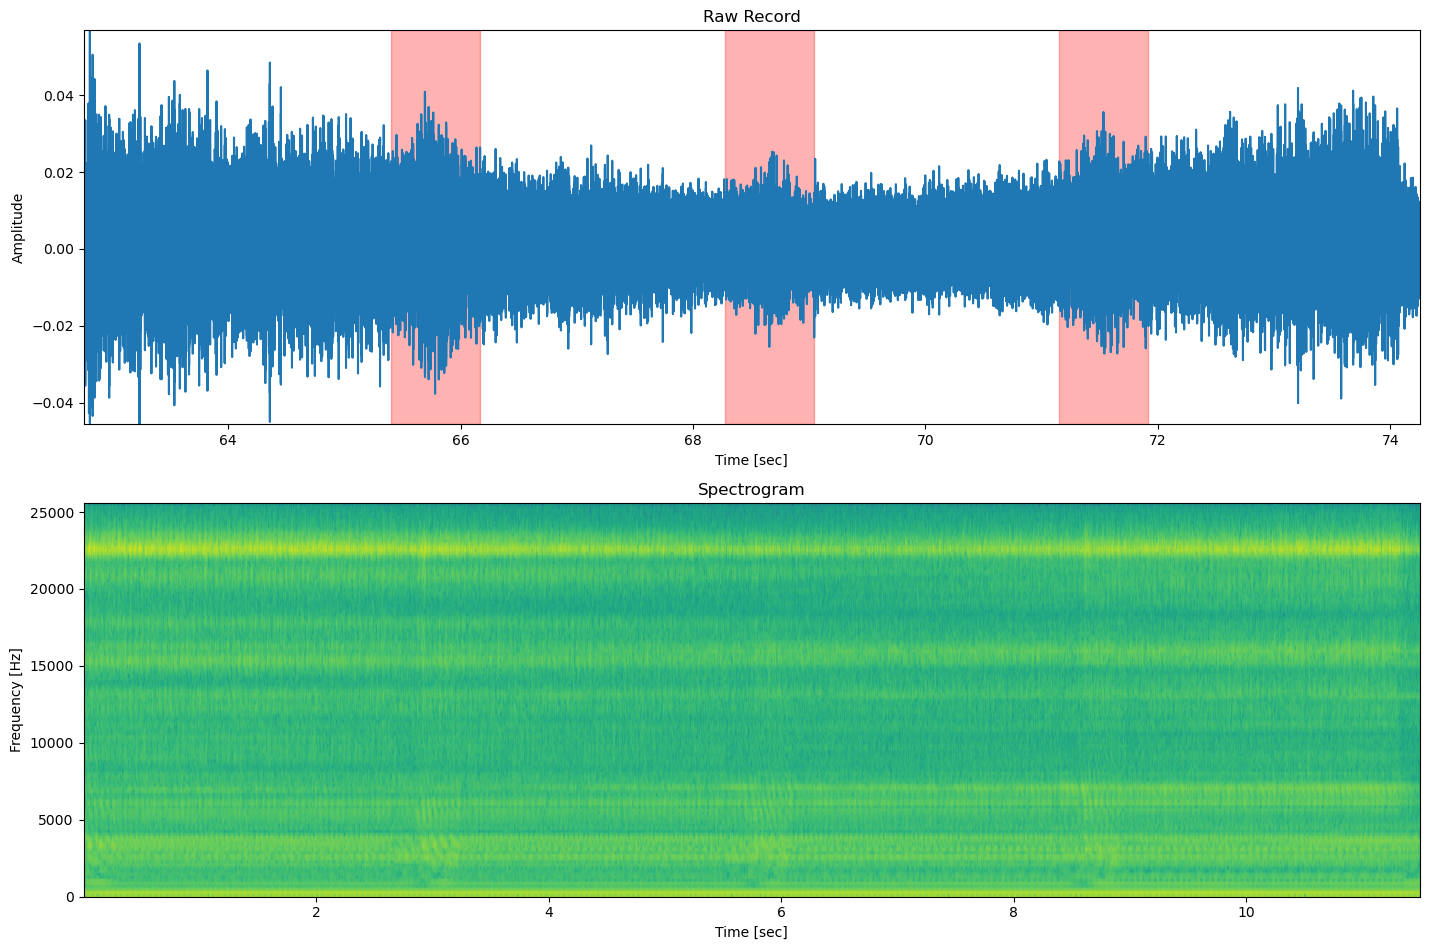

In [27]:
def plot_dashboard(vib_data, defects_time, params_current):
    #defects_time = fun.find_defect_windows(segments, segment_i)


    fs = 51200

    fig, axs = plt.subplots(2, 1, figsize=(12 * 1.2, 8 * 1.2))

    # Plot raw time domain
    axs[0].plot(vib_data)
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Amplitude')
    axs[0].margins(x=0, y=0)
    axs[0].set_title('Raw Record')

    # Plot defects
    for i in range(len(defects_time)):
        axs[0].axvspan(defects_time[i][0], defects_time[i][1], alpha=0.3, color='red', label='actual cut')

    # Plot spectrogram
    axs[1].specgram(x=vib_data, Fs=fs)
    axs[1].set_ylabel('Frequency [Hz]')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_title('Spectrogram')
    
    #format current context
    print(params_current["direct"])
    direct_num = None
    if params_current["direct"] == "Gegen1" or params_current["direct"] == "Gegen":
        direct_num = 0
    if params_current["direct"] == "Gleich":
        direct_num = 1
    filename = f'FULL:a_e:{params_current["a_e"]}v_c:{params_current["v_c"]}f_z:{params_current["f_z"]}a_p:{int(params_current["a_p"])}d:{int(params_current["d"])}flutes:{int(params_current["flutes"])}direct:{direct_num}'

    plt.tight_layout()
    plt.show()
    #plt.savefig(f'dashboardplots/{filename}.png')
    #plt.close(fig)
    
    

    
vib_data= vibseg
plot_dashboard_FULL(vib_data, defects_time, params_current)



In [25]:
def plot_fregments_dashboard(defect_subsets, non_defect_subsets, params_ranges, params_current):

    fs = 51200
    fig, axs = plt.subplots(3, 2, figsize=(12 * 1.2, 8 * 1.2))
    
    #Spectrogram DEFECT
    for i, defect_subset in enumerate(defect_subsets):
        axs[i,0].specgram(x=defect_subset, Fs=fs)
        axs[i,0].set_ylabel('Frequency [Hz]')
        axs[i,0].set_xlabel('Time [sec]')
        axs[i,0].set_title('Defect '+ str(i))

    #Spectrogram NORMAL
    for i, non_defect_subset in enumerate(non_defect_subsets):
        axs[i,1].specgram(x=non_defect_subset, Fs=fs)
        axs[i,1].set_ylabel('Frequency [Hz]')
        axs[i,1].set_xlabel('Time [sec]')
        axs[i,1].set_title('Normal '+ str(i))
        
    plt.tight_layout()
    plt.show()

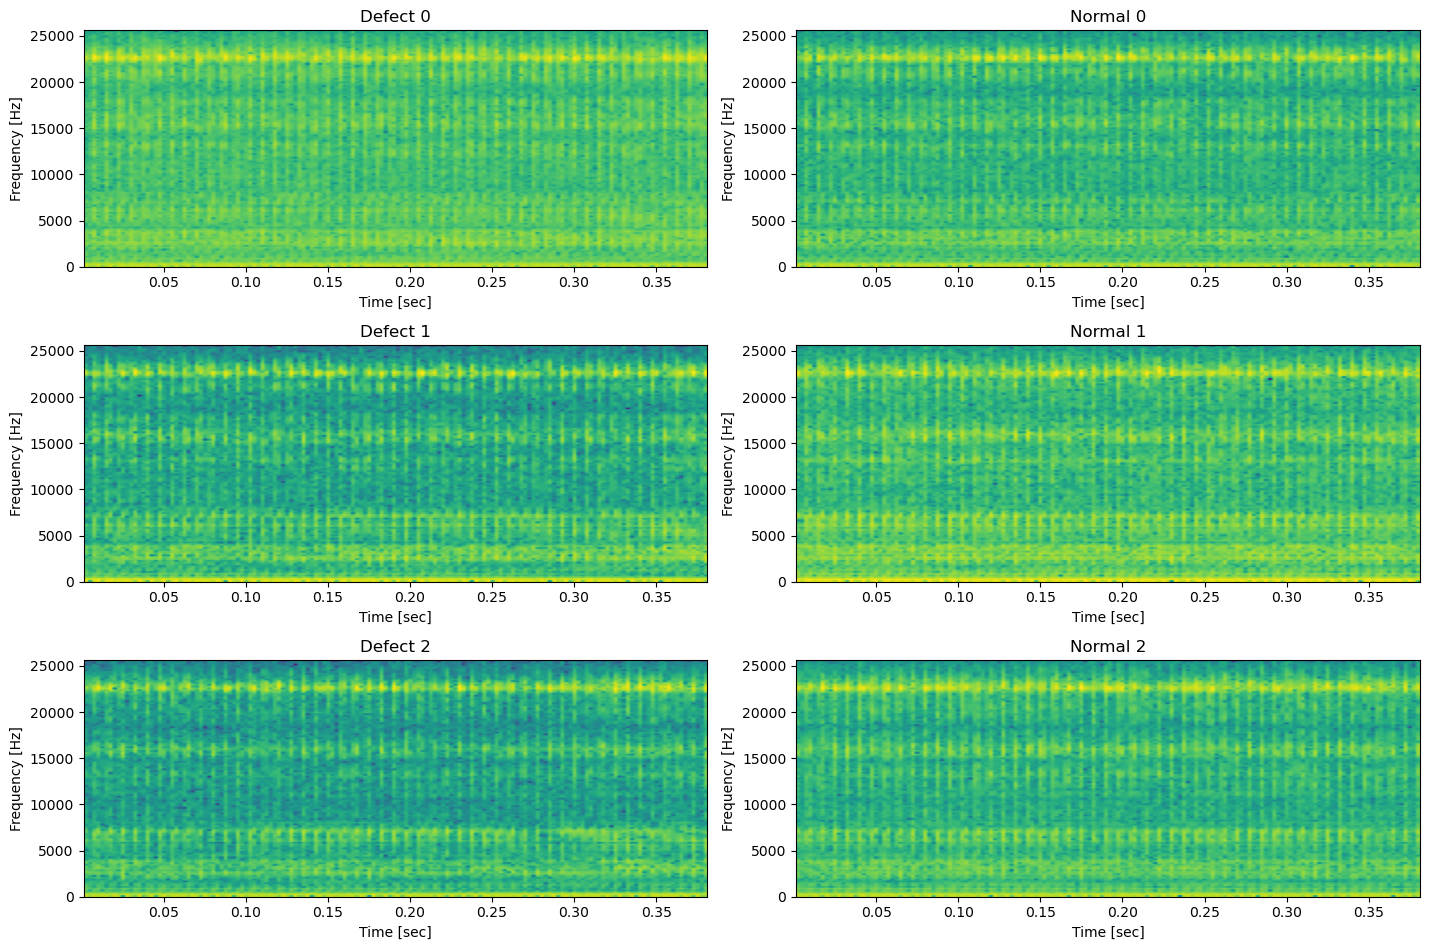

In [26]:
plot_fregments_dashboard(defect_subsets, non_defect_subsets, params_ranges, params_current)


In [ ]:
vibseg = fun.select_vibdata(vibdata, segments, segment_i)
vibseg

# ==============================

In [9]:
filenames = []
for segment_i in range(len(plane_context)):
    params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
    filename = fun.safeplots_dashboard(vibdata, segments, segment_i, params_ranges, params_current)
    filenames.append(filename)
    print(segment_i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [10]:
import os

def check_files_existence(directory, filenames, filetype):
    i=0
    for filename in filenames:
        filename = filename+filetype
        file_path = os.path.join(directory, filename)
        if not os.path.exists(file_path):
            print(f"!!! File not found: {file_path}")
        i+=1

directory_path = "dashboardplots"
filetype = ".png"
check_files_existence(directory_path, filenames, filetype)




def find_duplicate_filenames(filenames):
    seen = set()
    duplicates = set()

    for filename in filenames:
        if filename in seen:
            duplicates.add(filename)
        else:
            seen.add(filename)

    return list(duplicates)

duplicates = find_duplicate_filenames(filenames)
print(duplicates)

[]


# ================ 0_1

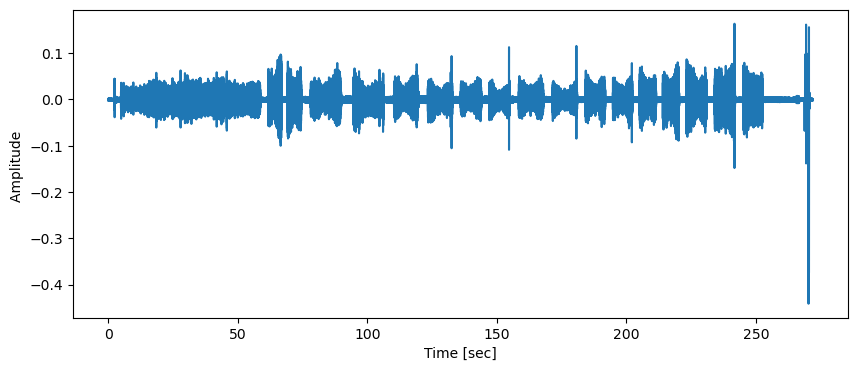

21


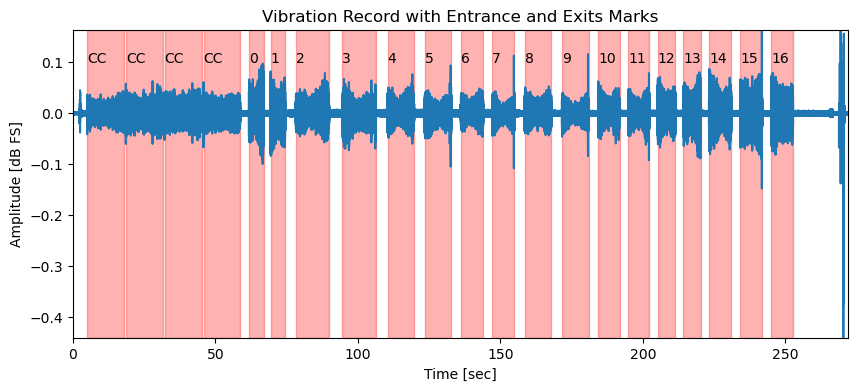

In [11]:
#record import:
record = pd.read_csv('Xbignew_0_1_t2.csv') #X1_1_28_09  19_6_3
record = record.drop(record.columns[2], axis=1) #drop 3rd (empty) column

record["time"] = np.arange(len(record[' Chan 1']))/51200
record = record.set_index(["time"])

y = record[' Chan 1']#.iloc[300000 : 301000]

fs = 51200 #samplerate
samples = len(y) #total number of samples
x = np.arange(samples) / fs #array of timestamps

vibdata = record[' Chan 1']

plt.plot(x,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude ')
plt.show()
record

smoothed_envelop = fun.envelope_F(vibdata, window_size=5)
segments = fun.find_higher_vibration_segments(np.array(smoothed_envelop), threshold=0.01)
print(len(segments))
fun.plot_timewindowing(segments, vibdata)

In [12]:
plane_context = fun.open_pkl("context_0_1.pkl")
print(len(plane_context))

filenames = []
for segment_i in range(len(plane_context)):
    params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
    filename = fun.safeplots_dashboard(vibdata, segments, segment_i, params_ranges, params_current)
    filenames.append(filename)
    print(segment_i)

16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [13]:
# tests and checks...
directory_path = "dashboardplots"
filetype = ".png"
check_files_existence(directory_path, filenames, filetype)


duplicates = find_duplicate_filenames(filenames)
print(duplicates)

[]


# ================ 0_2

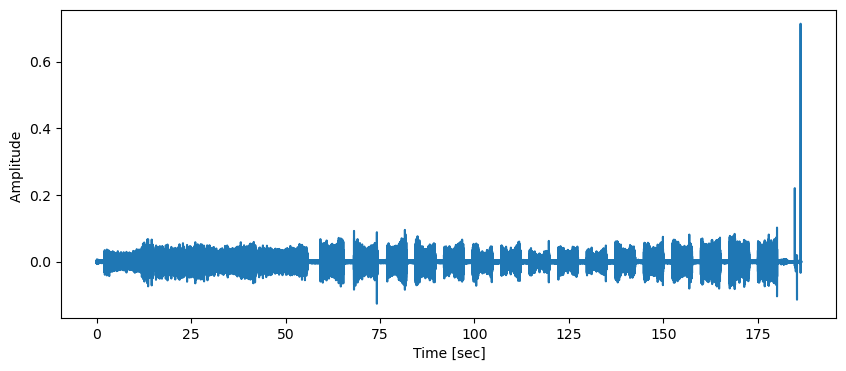

20


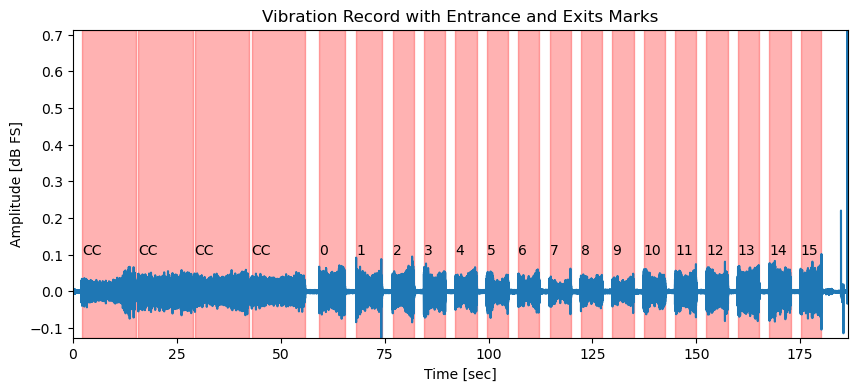

In [14]:
#record import:
record = pd.read_csv('Xbignew_0_2.csv') #X1_1_28_09  19_6_3
record = record.drop(record.columns[2], axis=1) #drop 3rd (empty) column

record["time"] = np.arange(len(record[' Chan 1']))/51200
record = record.set_index(["time"])

y = record[' Chan 1']#.iloc[300000 : 301000]

fs = 51200 #samplerate
samples = len(y) #total number of samples
x = np.arange(samples) / fs #array of timestamps

vibdata = record[' Chan 1']

plt.plot(x,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude ')
plt.show()
record

smoothed_envelop = fun.envelope_F(vibdata, window_size=5)
segments = fun.find_higher_vibration_segments(np.array(smoothed_envelop), threshold=0.01)
print(len(segments))
fun.plot_timewindowing(segments, vibdata)

In [15]:
plane_context = fun.open_pkl("context_0_2.pkl")
print(len(plane_context))

filenames = []
for segment_i in range(len(plane_context)):
    params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
    filename = fun.safeplots_dashboard(vibdata, segments, segment_i, params_ranges, params_current)
    filenames.append(filename)
    print(segment_i)

4
0
1
2
3


In [16]:
# tests and checks...
directory_path = "dashboardplots"
filetype = ".png"
check_files_existence(directory_path, filenames, filetype)


duplicates = find_duplicate_filenames(filenames)
print(duplicates)

[]


# ================ 0_3

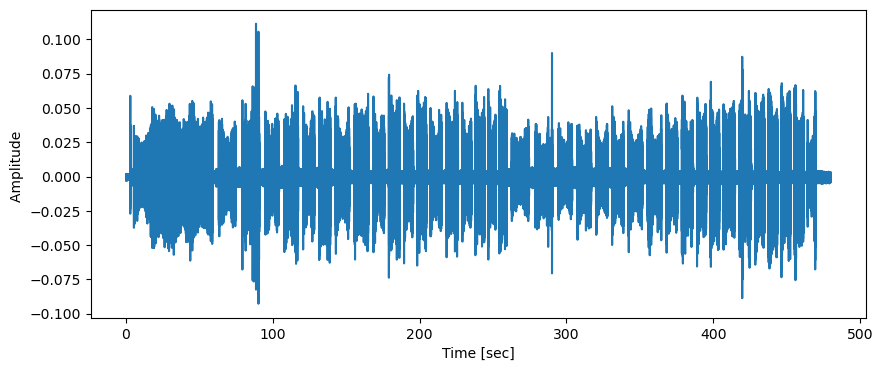

40


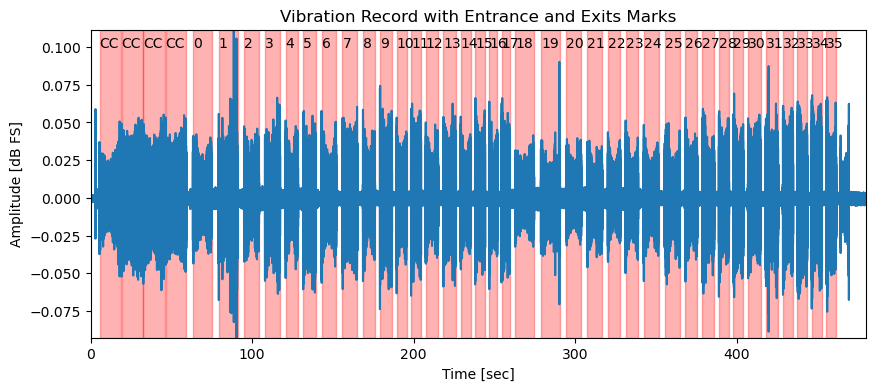

In [17]:
#record import:
record = pd.read_csv('Xbignew_0_3.csv') #X1_1_28_09  19_6_3
record = record.drop(record.columns[2], axis=1) #drop 3rd (empty) column

record["time"] = np.arange(len(record[' Chan 1']))/51200
record = record.set_index(["time"])

y = record[' Chan 1']#.iloc[300000 : 301000]

fs = 51200 #samplerate
samples = len(y) #total number of samples
x = np.arange(samples) / fs #array of timestamps

vibdata = record[' Chan 1']

plt.plot(x,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude ')
plt.show()
record

smoothed_envelop = fun.envelope_F(vibdata, window_size=5)
segments = fun.find_higher_vibration_segments(np.array(smoothed_envelop), threshold=0.01)
print(len(segments))
fun.plot_timewindowing(segments, vibdata)

In [18]:
plane_context = fun.open_pkl("context_0_3.pkl")
print(len(plane_context))

filenames = []
for segment_i in range(len(plane_context)):
    params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
    filename = fun.safeplots_dashboard(vibdata, segments, segment_i, params_ranges, params_current)
    filenames.append(filename)
    print(segment_i)

34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [19]:
# tests and checks...
directory_path = "dashboardplots"
filetype = ".png"
check_files_existence(directory_path, filenames, filetype)


duplicates = find_duplicate_filenames(filenames)
print(duplicates)

[]


# ================ 0_4

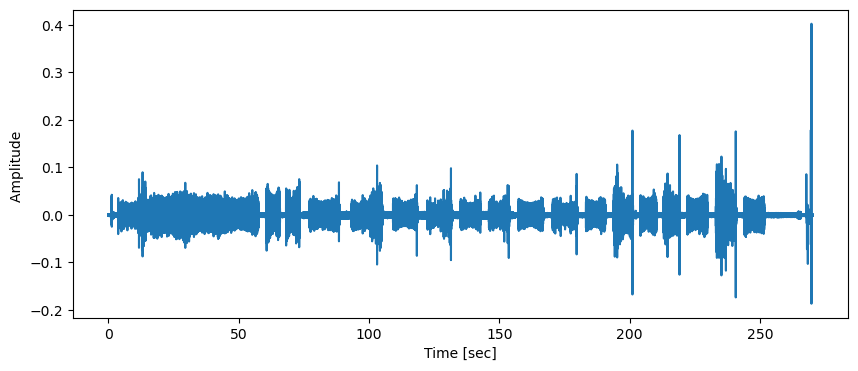

21


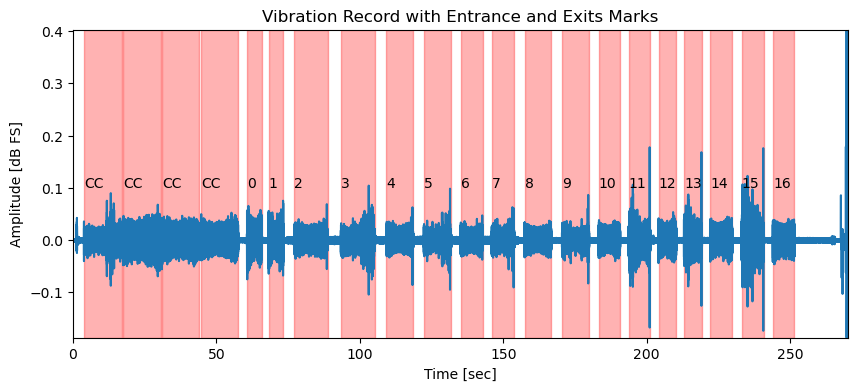

In [20]:
#record import:
record = pd.read_csv('Xbignew_0_4.csv') #X1_1_28_09  19_6_3
record = record.drop(record.columns[2], axis=1) #drop 3rd (empty) column

record["time"] = np.arange(len(record[' Chan 1']))/51200
record = record.set_index(["time"])

y = record[' Chan 1']#.iloc[300000 : 301000]

fs = 51200 #samplerate
samples = len(y) #total number of samples
x = np.arange(samples) / fs #array of timestamps

vibdata = record[' Chan 1']

plt.plot(x,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude ')
plt.show()
record

smoothed_envelop = fun.envelope_F(vibdata, window_size=5)
segments = fun.find_higher_vibration_segments(np.array(smoothed_envelop), threshold=0.01)
print(len(segments))
fun.plot_timewindowing(segments, vibdata)

In [21]:
plane_context = fun.open_pkl("context_0_4.pkl")
print(len(plane_context))

filenames = []
for segment_i in range(len(plane_context)):
    params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
    filename = fun.safeplots_dashboard(vibdata, segments, segment_i, params_ranges, params_current)
    filenames.append(filename)
    print(segment_i)

16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [22]:
# tests and checks...
directory_path = "dashboardplots"
filetype = ".png"
check_files_existence(directory_path, filenames, filetype)


duplicates = find_duplicate_filenames(filenames)
print(duplicates)

[]


# ================ 0_5

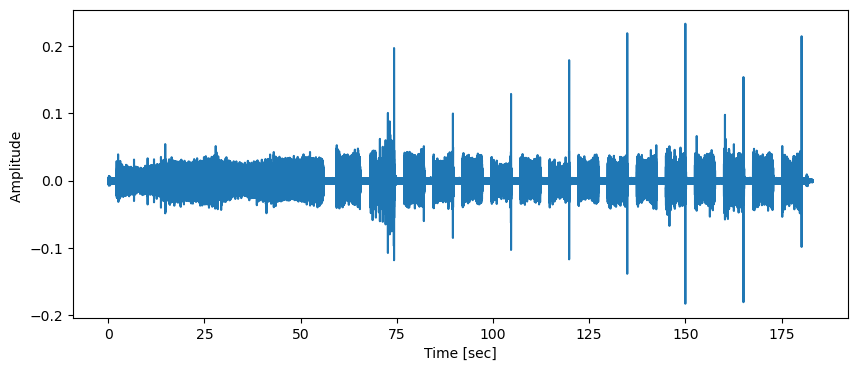

20


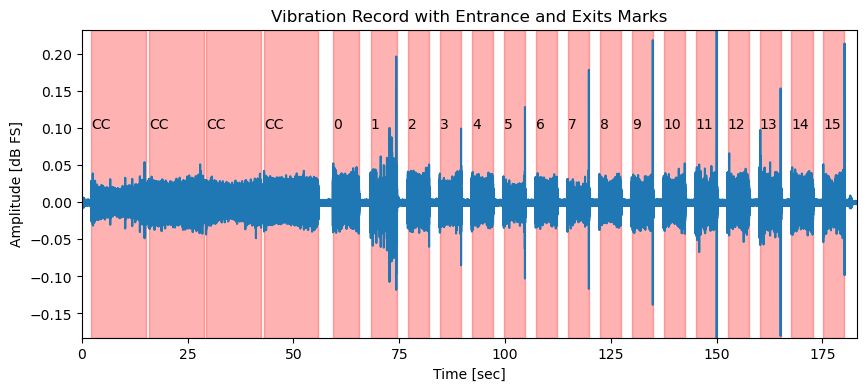

In [23]:
#record import:
record = pd.read_csv('Xbignew_0_5.csv') #X1_1_28_09  19_6_3
record = record.drop(record.columns[2], axis=1) #drop 3rd (empty) column

record["time"] = np.arange(len(record[' Chan 1']))/51200
record = record.set_index(["time"])

y = record[' Chan 1']#.iloc[300000 : 301000]

fs = 51200 #samplerate
samples = len(y) #total number of samples
x = np.arange(samples) / fs #array of timestamps

vibdata = record[' Chan 1']

plt.plot(x,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude ')
plt.show()
record

smoothed_envelop = fun.envelope_F(vibdata, window_size=5)
segments = fun.find_higher_vibration_segments(np.array(smoothed_envelop), threshold=0.01)
print(len(segments))
fun.plot_timewindowing(segments, vibdata)

In [24]:
plane_context = fun.open_pkl("context_0_5.pkl")
print(len(plane_context))

filenames = []
for segment_i in range(len(plane_context)):
    params_ranges, params_current = fun.get_segment_context_params(plane_context, segment_i)
    filename = fun.safeplots_dashboard(vibdata, segments, segment_i, params_ranges, params_current)
    filenames.append(filename)
    print(segment_i)

4
0
1
2
3


In [25]:
# tests and checks...
directory_path = "dashboardplots"
filetype = ".png"
check_files_existence(directory_path, filenames, filetype)


duplicates = find_duplicate_filenames(filenames)
print(duplicates)

[]
